STAT 479 Midterm Exam by Cory Suzuki

In [26]:
# Import all necessary libraries. 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras as keras
import tensorflow as tf
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
import keras_tuner as kt
from sklearn.compose import make_column_transformer, ColumnTransformer
from tensorflow.keras.regularizers import l2
from sklearn.pipeline import Pipeline
from ucimlrepo import fetch_ucirepo
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

1. Dataset Selection

• Select a dataset with both numerical and categorical features and a clear 
categorical target variable. 
• Include a brief description of the dataset and its target variable. Sample 
proportions according to the target variable should be reported. 

The dataset of choice is the USIIL Phishing URL dataset which is helpful in detecting if an email's url indicates that it is a phishing email or not. This is mainly used in scam and fraud detection for online e-commerce and markets. The target variable of interest is the "label" which indicates 1 for a phishing url and a 0 for a non-phishing url. There are 55 other features which are either integers or categorical, and reveal different aspects of a url such as its number of subdomains, number of self-redirects, type of domain extension, and so forth. For a table of the features, please refer to the UCI Machine Learning repository website as the number of feature listings in a table has slowed down my personal machine. Link: https://archive.ics.uci.edu/dataset/967/phiusiil+phishing+url+dataset

For sampling ratio, since this dataset has 235795 rows and 56 columns, it is quite a large dataset. Below is a step-by-step process of how we preprocess the data. Irrelevant features of disinterest were removed and a sampling ratio of 10% was used to create a representative sample of 10% from the population (entire dataset) for our new data so our machines do not break or overheat. Our research hypothesis here is quite elementary, we aim to investigate the accuracy of a multilayer feed-forward neural network onto this dataset and test the hypotheses:

$H_{o} : \text{We will not have substantial accuracy improvement}\\
H_{1} : \text{We will have substantial accuracy improvement}$

Firstly, we being with preprocessing of the dataset.

In [2]:
# Import and load the data. We will be using the Phishing Dataset. 

phishing_data = pd.read_csv("C:/Users/coryg/OneDrive/Desktop/STAT_479_Deep_Learning/PhiUSIIL_Phishing_URL_Dataset.csv", delimiter=",")
phishing_data.head(15)

,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.000000,1.000000,0.522907,...,0,0,1,34,20,28,119,0,124,1
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.000000,0.666667,0.032650,...,0,0,1,50,9,8,39,0,217,1
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.000000,0.866667,0.028555,...,0,0,1,10,2,7,42,2,5,1
3,554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.000000,1.000000,0.522907,...,1,1,1,3,27,15,22,1,31,1
4,151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.000000,1.000000,0.079963,...,1,0,1,244,15,34,72,1,85,1
5,23107.txt,https://www.globalreporting.org,30,www.globalreporting.org,23,0,org,100.000000,1.000000,0.079963,...,0,0,1,35,1,11,86,0,14,1
6,23034.txt,https://www.saffronart.com,25,www.saffronart.com,18,0,com,100.000000,1.000000,0.522907,...,0,0,1,32,4,14,44,2,17,1
7,696732.txt,https://www.nerdscandy.com,25,www.nerdscandy.com,18,0,com,100.000000,1.000000,0.522907,...,0,0,1,24,2,22,36,0,15,1
8,739255.txt,https://www.hyderabadonline.in,29,www.hyderabadonline.in,22,0,in,100.000000,1.000000,0.005084,...,0,0,1,71,4,9,40,1,317,1
9,14486.txt,https://www.aap.org,18,www.aap.org,11,0,org,100.000000,1.000000,0.079963,...,0,0,1,10,1,12,173,6,65,1


In [3]:
# Check the shape and dimensions of the dataset. 

print(phishing_data.shape)

(235795, 56)


2. Data Cleaning

• Handle missing values: Impute numerical features using median or KNN 
imputation and categorical features using mode imputation (or another method 
with justification).

As stated in the introduction, there are no missing values, so we skip this step.

At the preprocessing stage 1 step, we will remove features of unnecessary interest since the dataset is quite large. If necessary, feature selection by correlation may be employed to mitigate any effects of multicollinearity and eliminate any potential redundancies within the phishing dataset.

In [4]:
# Preprocessing Stage 1: Remove all unnecessary features (not of interest). 

phishing_data = phishing_data.drop(columns=["FILENAME", "URL", "Domain", "Title",
                                            "HasObfuscation", "NoOfObfuscatedChar",
                                            "ObfuscationRatio", "TLD",
                                            "NoOfAmpersandInURL","TLDLength",
                                            ], axis=1)
phishing_data.head(15)

,URLLength,DomainLength,IsDomainIP,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,NoOfSubDomain,NoOfLettersInURL,LetterRatioInURL,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,31,24,0,100.000000,1.000000,0.522907,0.061933,1,18,0.581,...,0,0,1,34,20,28,119,0,124,1
1,23,16,0,100.000000,0.666667,0.032650,0.050207,1,9,0.391,...,0,0,1,50,9,8,39,0,217,1
2,29,22,0,100.000000,0.866667,0.028555,0.064129,2,15,0.517,...,0,0,1,10,2,7,42,2,5,1
3,26,19,0,100.000000,1.000000,0.522907,0.057606,1,13,0.500,...,1,1,1,3,27,15,22,1,31,1
4,33,26,0,100.000000,1.000000,0.079963,0.059441,1,20,0.606,...,1,0,1,244,15,34,72,1,85,1
5,30,23,0,100.000000,1.000000,0.079963,0.060614,1,17,0.567,...,0,0,1,35,1,11,86,0,14,1
6,25,18,0,100.000000,1.000000,0.522907,0.063549,1,12,0.480,...,0,0,1,32,4,14,44,2,17,1
7,25,18,0,100.000000,1.000000,0.522907,0.060486,1,12,0.480,...,0,0,1,24,2,22,36,0,15,1
8,29,22,0,100.000000,1.000000,0.005084,0.056980,1,16,0.552,...,0,0,1,71,4,9,40,1,317,1
9,18,11,0,100.000000,1.000000,0.079963,0.070497,1,5,0.278,...,0,0,1,10,1,12,173,6,65,1


• Remove duplicates if present. 

In [5]:
# Preprocessing Stage 2: Check and remove any duplicate data. 

phishing_data = phishing_data.drop_duplicates()
print(phishing_data.shape)
phishing_data.head(15)

(234987, 46)


,URLLength,DomainLength,IsDomainIP,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,NoOfSubDomain,NoOfLettersInURL,LetterRatioInURL,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,31,24,0,100.000000,1.000000,0.522907,0.061933,1,18,0.581,...,0,0,1,34,20,28,119,0,124,1
1,23,16,0,100.000000,0.666667,0.032650,0.050207,1,9,0.391,...,0,0,1,50,9,8,39,0,217,1
2,29,22,0,100.000000,0.866667,0.028555,0.064129,2,15,0.517,...,0,0,1,10,2,7,42,2,5,1
3,26,19,0,100.000000,1.000000,0.522907,0.057606,1,13,0.500,...,1,1,1,3,27,15,22,1,31,1
4,33,26,0,100.000000,1.000000,0.079963,0.059441,1,20,0.606,...,1,0,1,244,15,34,72,1,85,1
5,30,23,0,100.000000,1.000000,0.079963,0.060614,1,17,0.567,...,0,0,1,35,1,11,86,0,14,1
6,25,18,0,100.000000,1.000000,0.522907,0.063549,1,12,0.480,...,0,0,1,32,4,14,44,2,17,1
7,25,18,0,100.000000,1.000000,0.522907,0.060486,1,12,0.480,...,0,0,1,24,2,22,36,0,15,1
8,29,22,0,100.000000,1.000000,0.005084,0.056980,1,16,0.552,...,0,0,1,71,4,9,40,1,317,1
9,18,11,0,100.000000,1.000000,0.079963,0.070497,1,5,0.278,...,0,0,1,10,1,12,173,6,65,1


Since the dataset population is 234,987 rows which would break most machines or
take a considerable time to run with our model, we decide to take a representative
random sample from the population and use this subset as our new dataset. To keep
it representative for large datasets, we ideally want a minimum of 10%, so our
new data should have 23,499 rows. This will suffice for this model.

In [7]:
# Preprocessing Stage 2.1: Take a representative random sample of the original
# population to reduce computational complexity and to ensure machine health.

phishing_samp = phishing_data.sample(n=23499, random_state=42)
phishing_samp.head(15)

,URLLength,DomainLength,IsDomainIP,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,NoOfSubDomain,NoOfLettersInURL,LetterRatioInURL,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
157069,22,16,0,76.388889,1.000000,0.522907,0.066252,1,10,0.455,...,0,0,0,0,0,0,0,0,1,0
39763,86,22,0,21.127790,0.611111,0.522907,0.040865,0,51,0.593,...,0,0,0,0,0,0,0,0,0,0
10315,32,24,0,73.750000,0.700000,0.522907,0.050150,1,19,0.594,...,0,0,0,0,0,0,0,0,3,0
222195,34,27,0,100.000000,1.000000,0.522907,0.054219,1,21,0.618,...,0,0,1,23,51,46,55,10,31,1
67586,19,10,0,79.272727,1.000000,0.522907,0.055364,0,9,0.474,...,0,0,0,0,0,1,0,0,0,0
87857,24,17,0,100.000000,1.000000,0.001659,0.062742,1,11,0.458,...,0,0,1,16,6,5,9,0,22,1
53957,17,10,0,100.000000,1.000000,0.000981,0.055078,1,4,0.235,...,0,0,1,15,8,6,7,0,5,1
60692,34,25,0,66.720000,0.809524,0.522907,0.045640,1,16,0.471,...,1,0,0,19,3,9,1,0,4,0
200942,25,19,0,74.888889,0.750000,0.001722,0.061726,2,12,0.480,...,0,0,0,0,0,0,1,0,1,0
193489,30,23,0,100.000000,0.812500,0.010086,0.068530,2,16,0.533,...,1,0,1,19,4,8,38,0,27,1


          URLLength  DomainLength    IsDomainIP  URLSimilarityIndex  \
count  23499.000000  23499.000000  23499.000000        23499.000000   
mean      34.175497     21.385080      0.002298           78.623421   
std       38.500665      9.138228      0.047883           28.843766   
min       13.000000      4.000000      0.000000            0.447426   
25%       23.000000     16.000000      0.000000           57.584095   
50%       27.000000     20.000000      0.000000          100.000000   
75%       34.000000     24.000000      0.000000          100.000000   
max     4032.000000     96.000000      1.000000          100.000000   

       CharContinuationRate  TLDLegitimateProb   URLCharProb  NoOfSubDomain  \
count          23499.000000       23499.000000  23499.000000   23499.000000   
mean               0.846476           0.261895      0.055664       1.163922   
std                0.215875           0.251691      0.010605       0.600046   
min                0.000000           0.0000

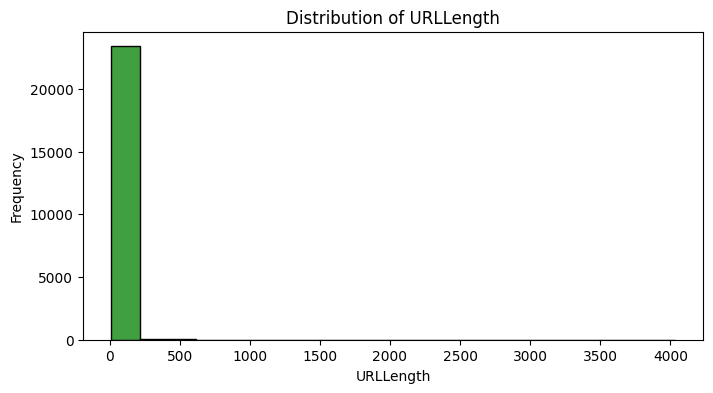

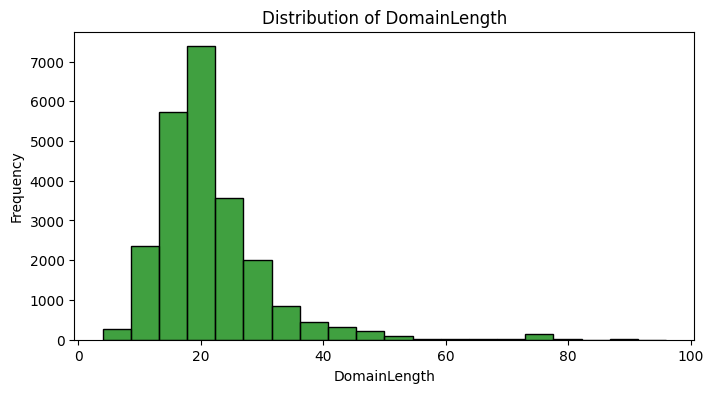

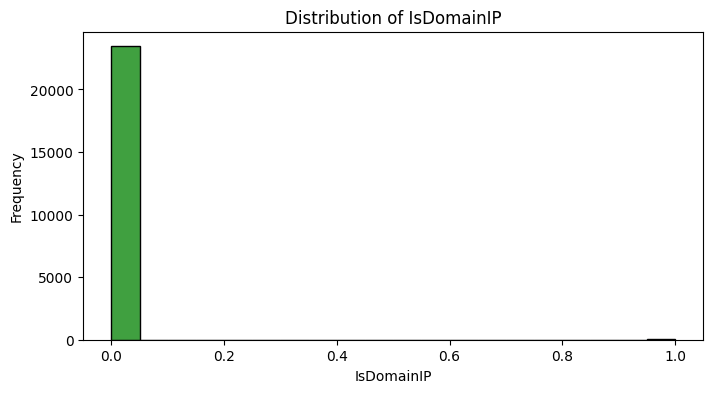

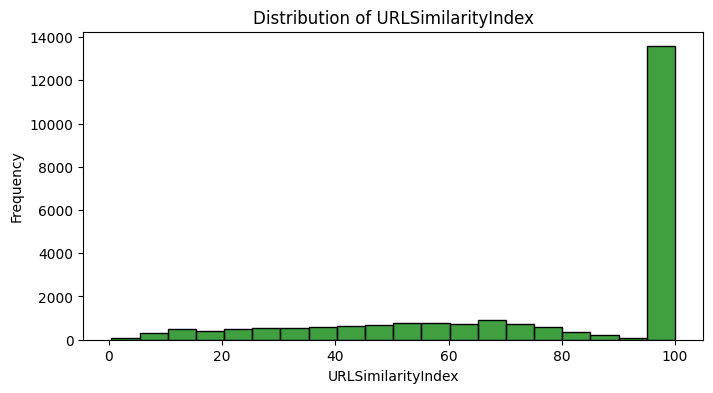

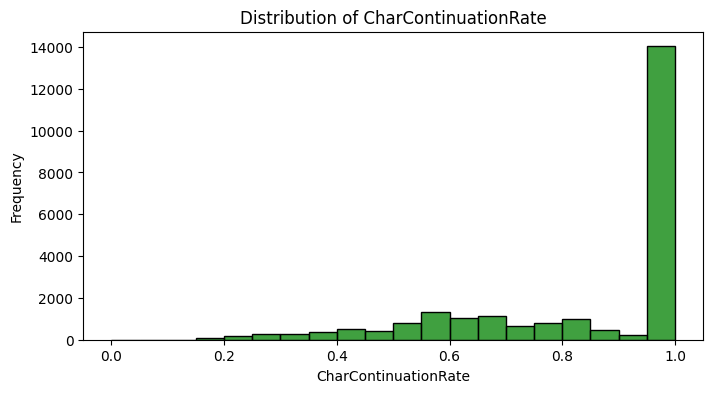

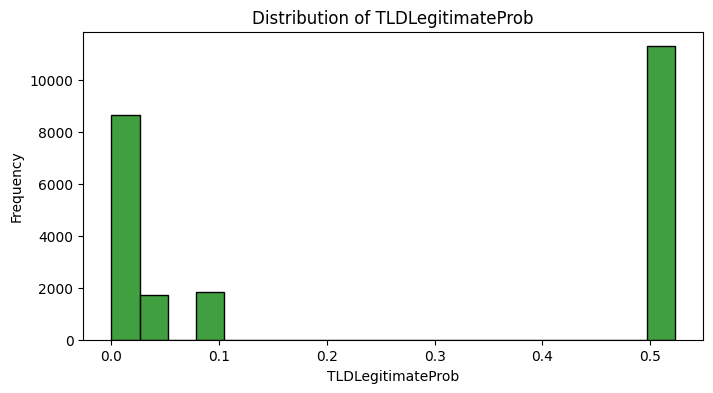

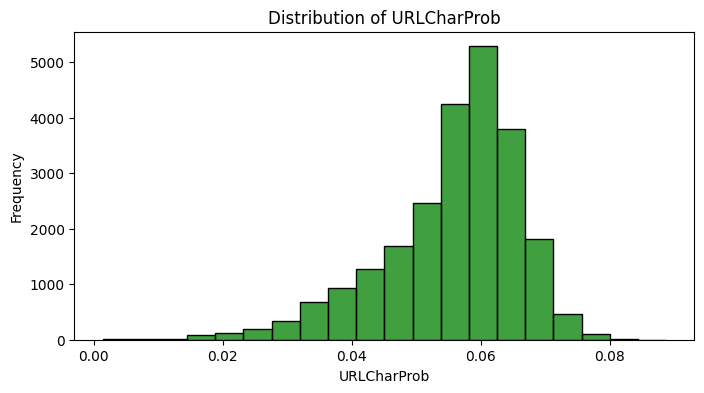

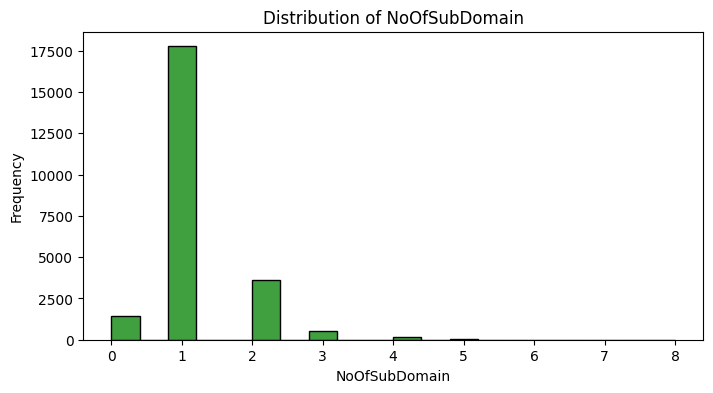

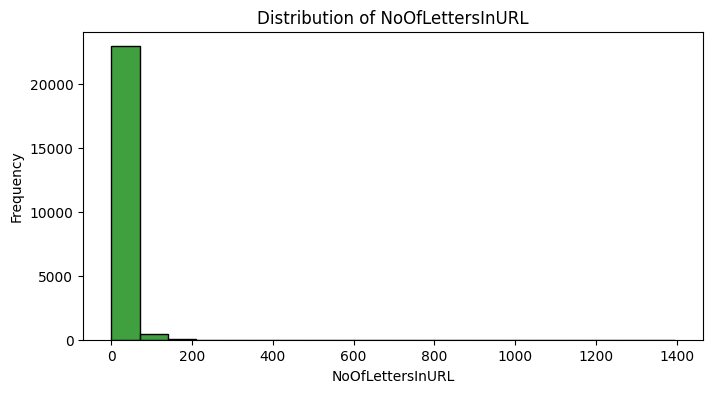

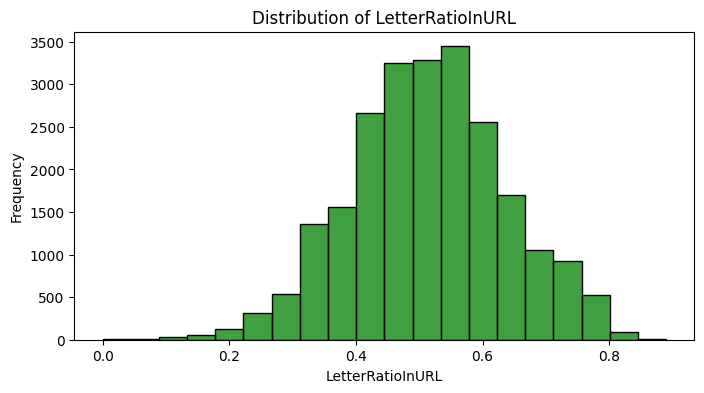

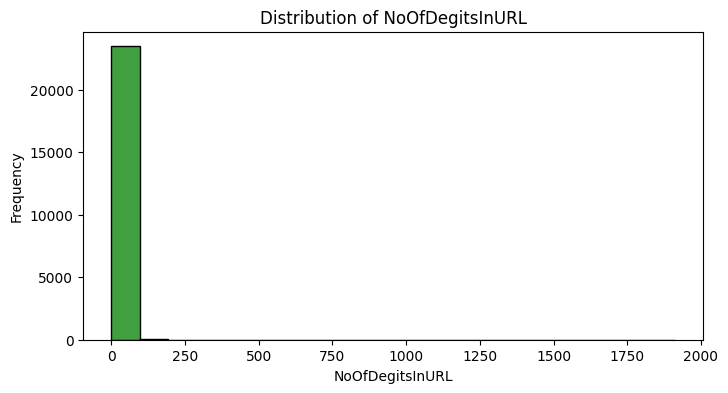

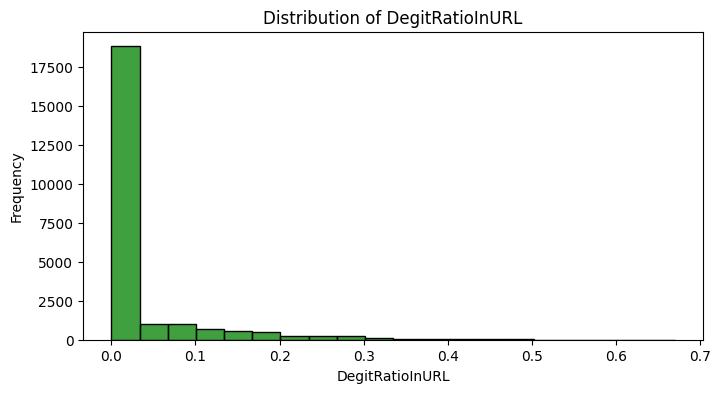

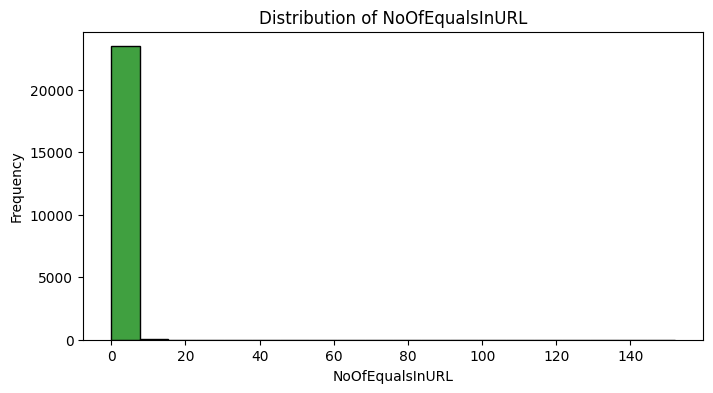

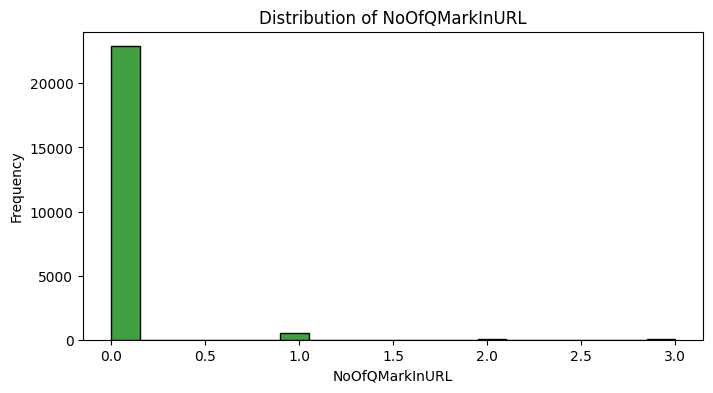

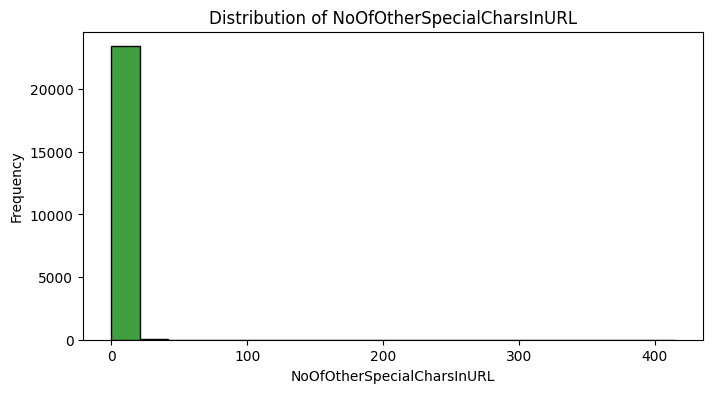

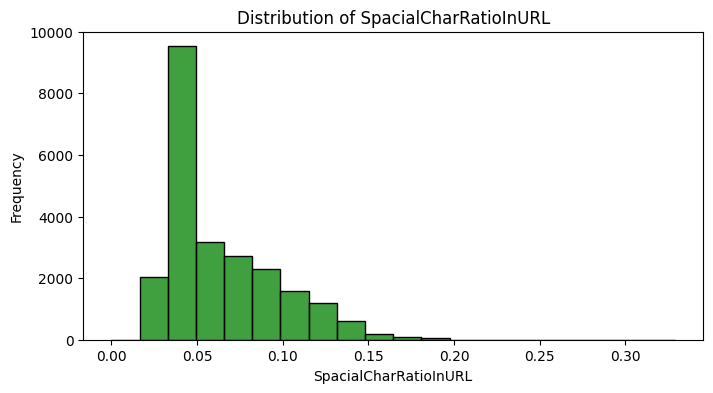

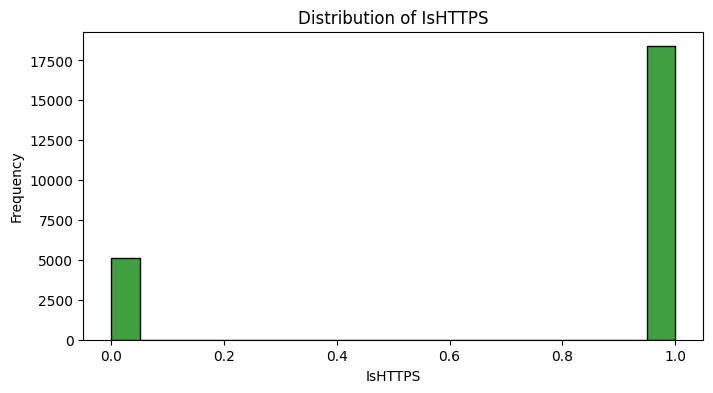

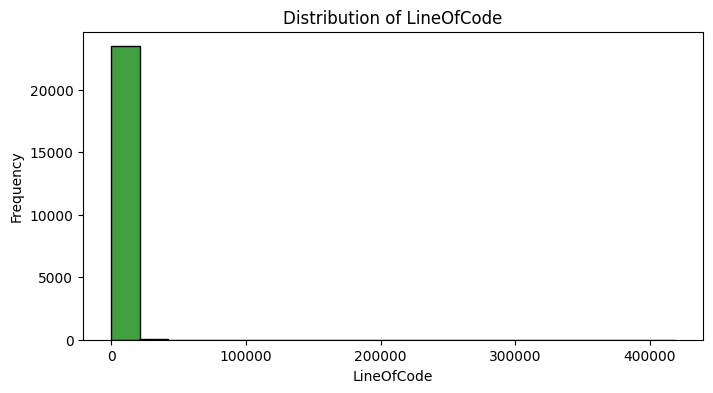

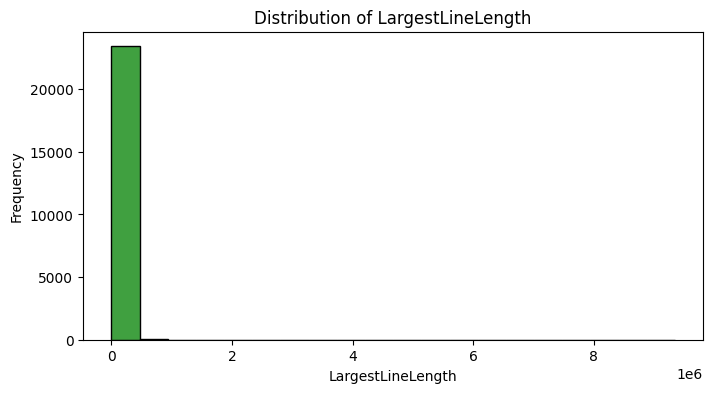

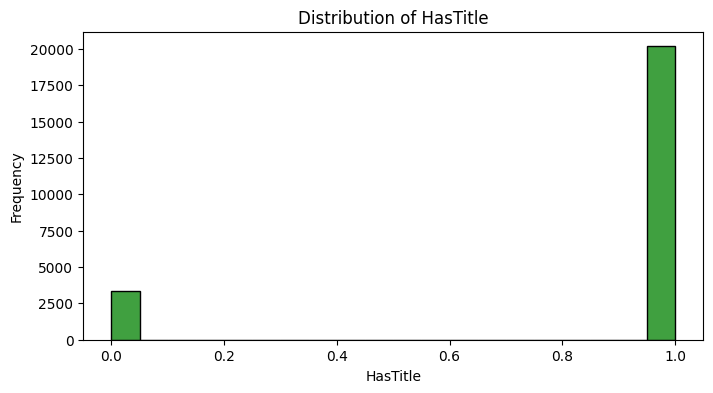

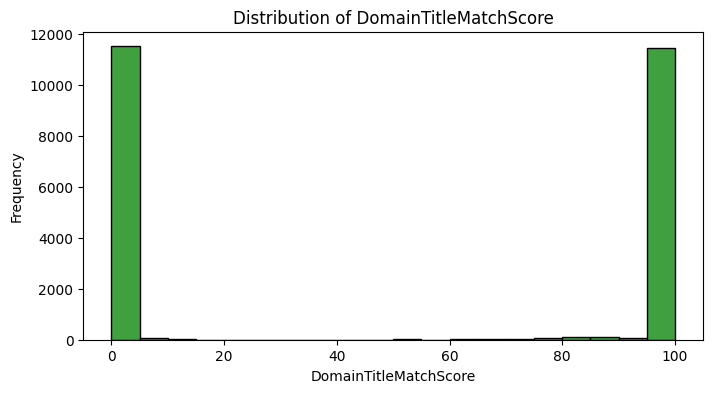

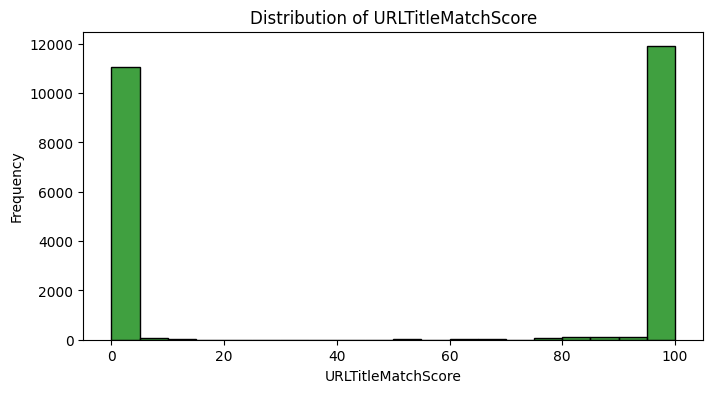

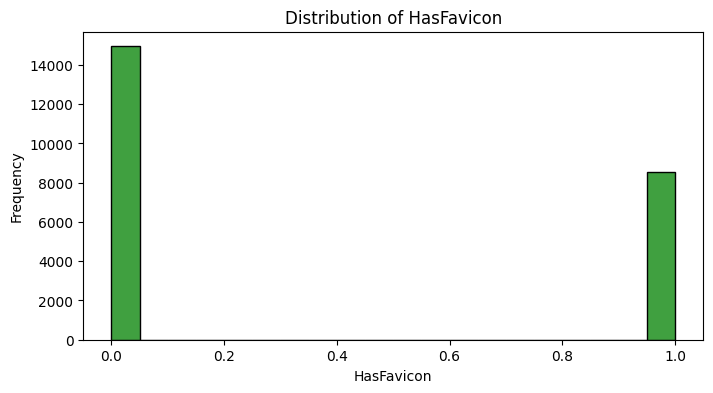

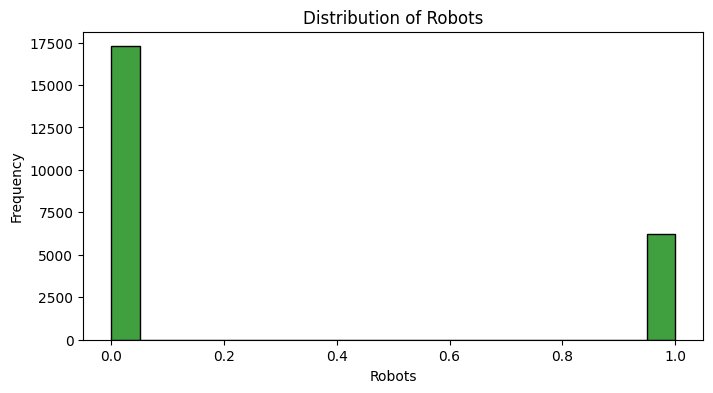

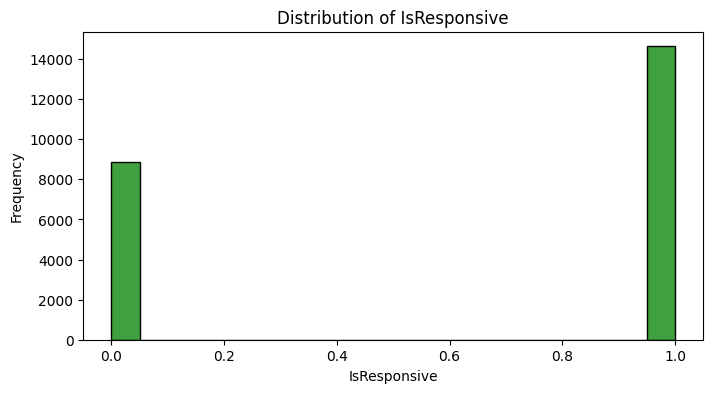

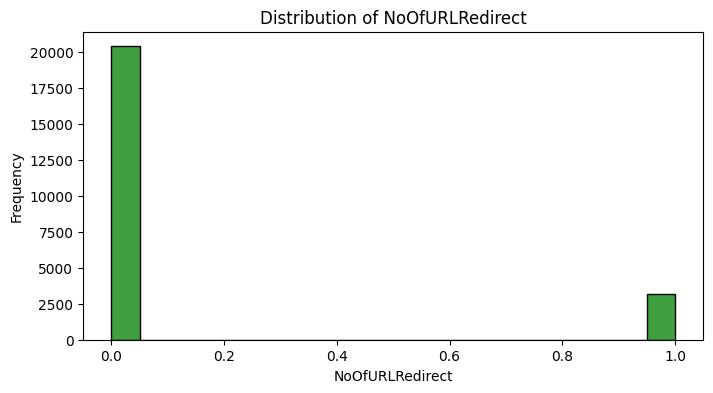

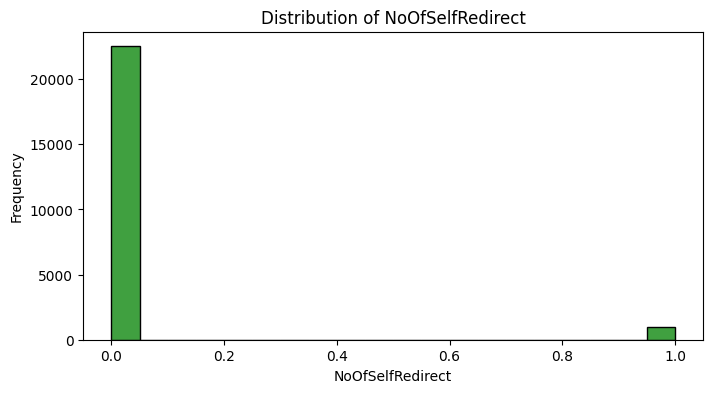

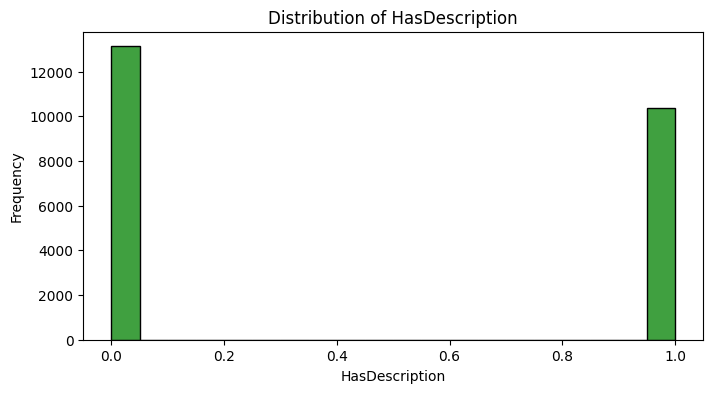

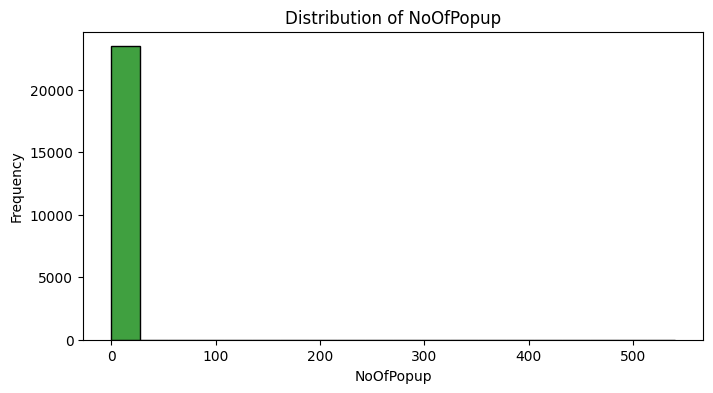

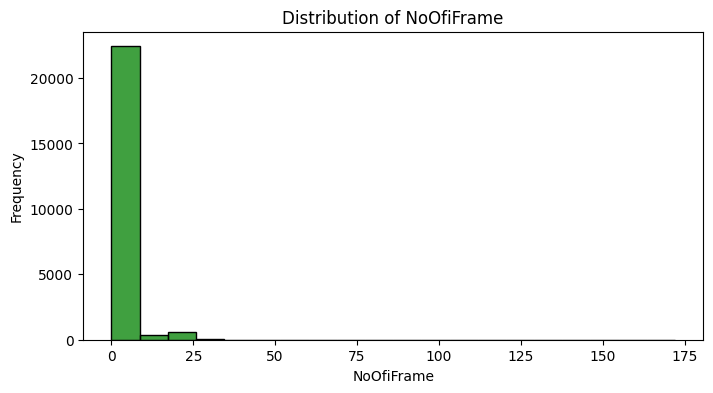

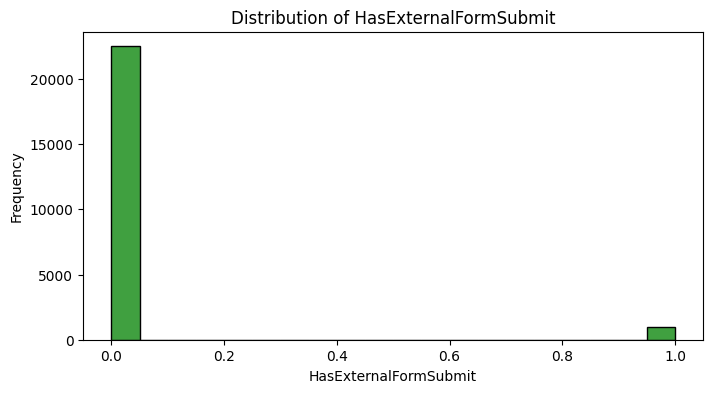

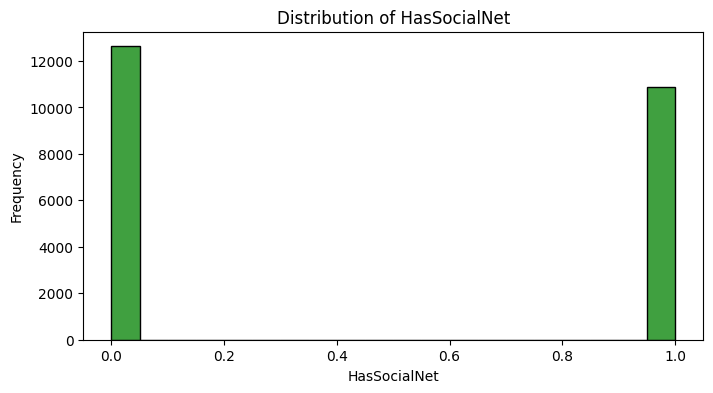

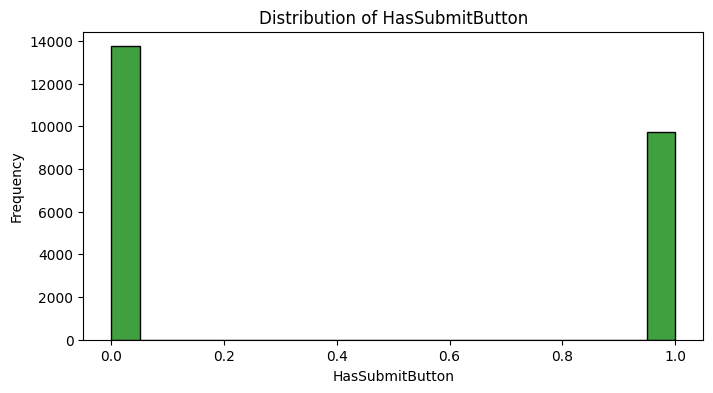

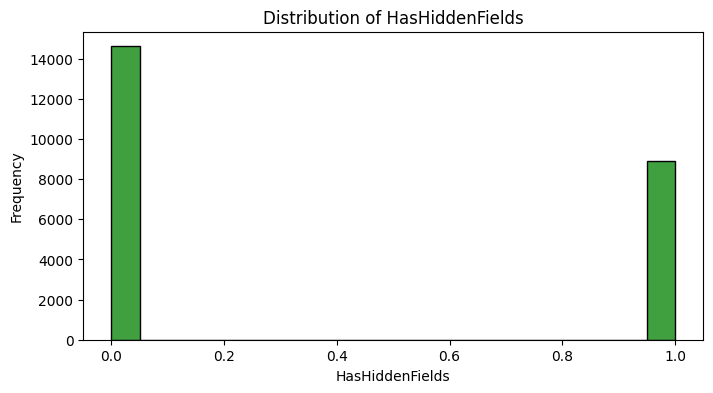

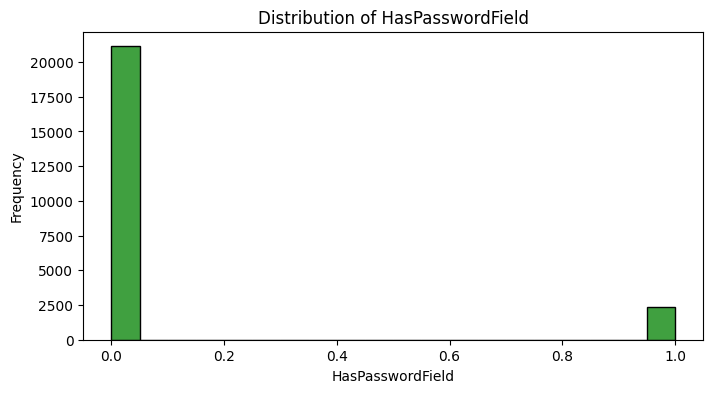

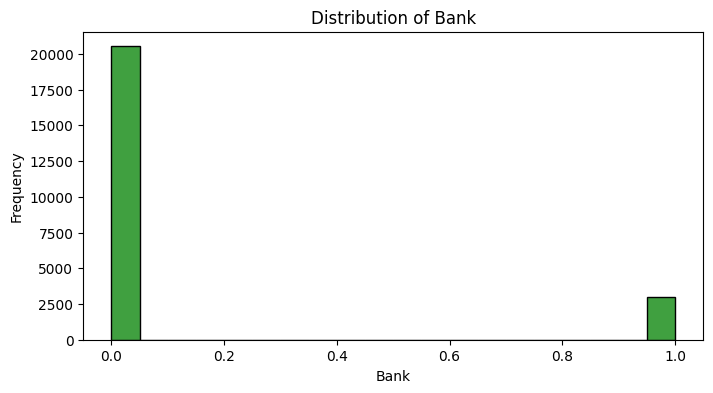

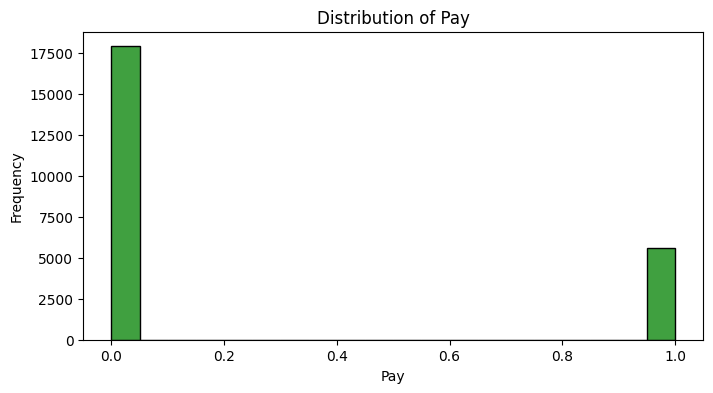

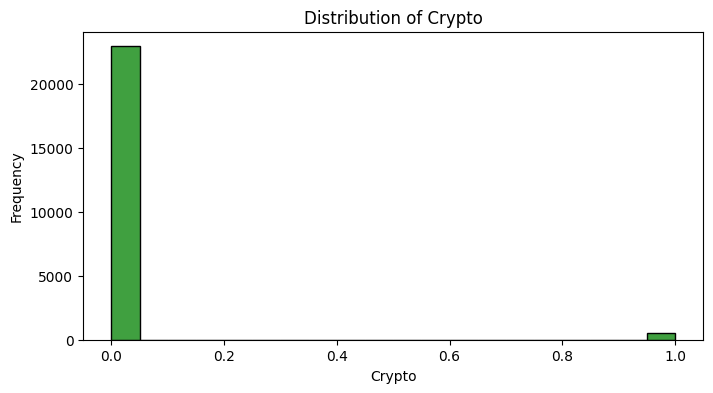

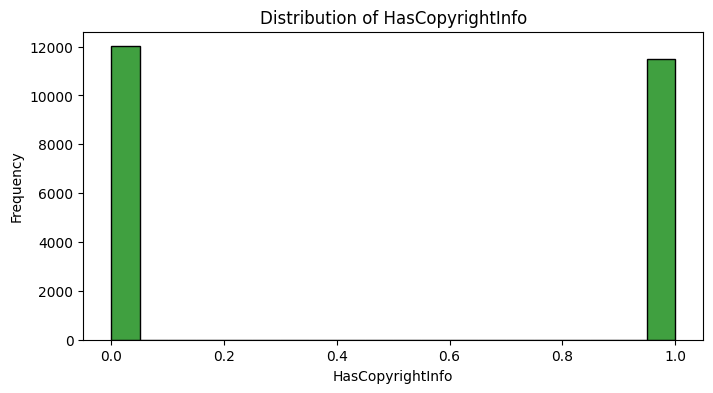

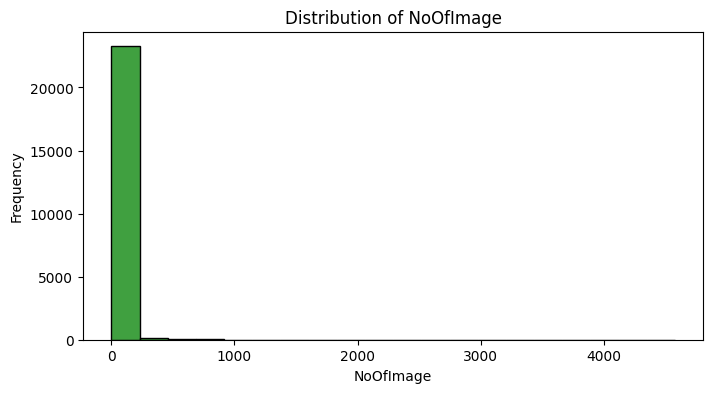

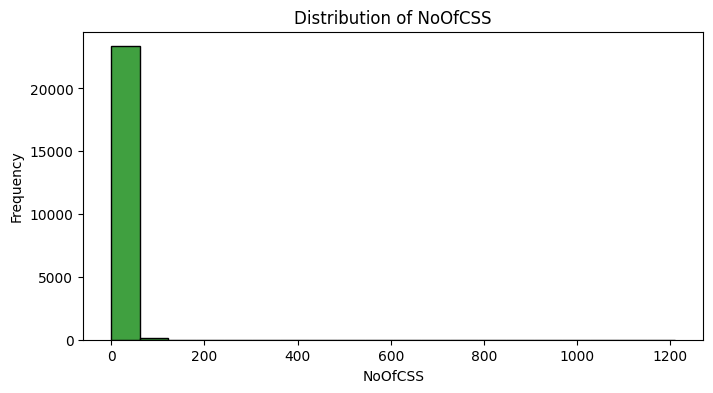

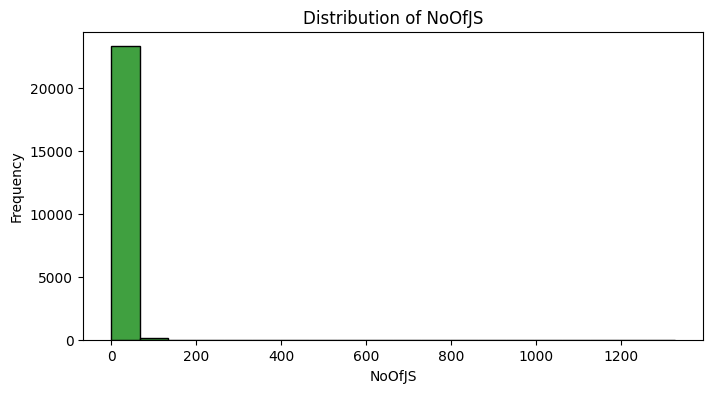

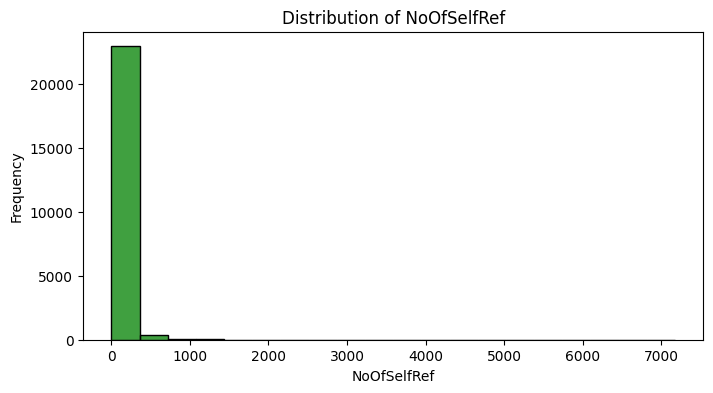

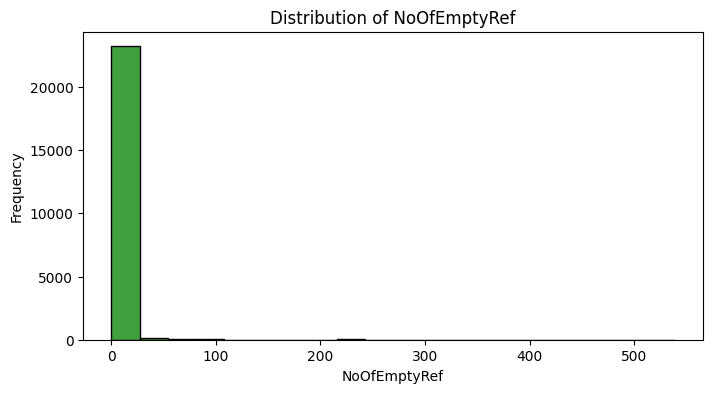

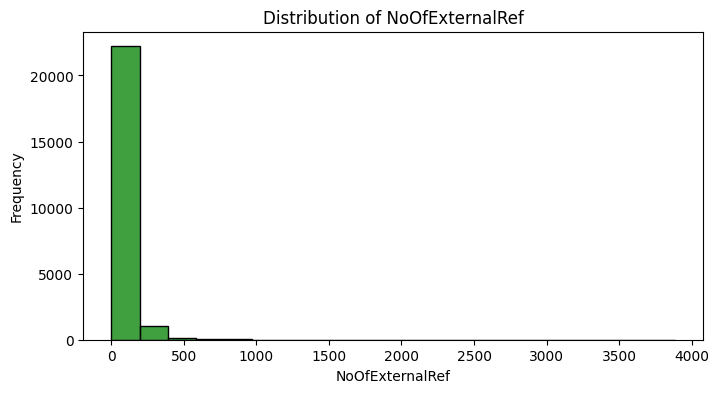

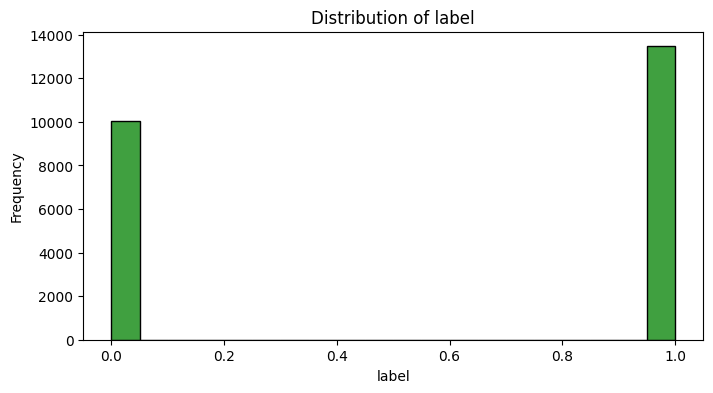

In [16]:
# Check the distribution of each feature using histograms and describe() for summary statistics. 

print(phishing_samp.describe())

for column in phishing_samp:
    plt.figure(figsize=(8,4))
    sns.histplot(phishing_samp[column], bins=20, color="green") 
    plt.title(f"Distribution of {column}") 
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()

Now we need to check each of the feature datatypes to ensure that the model can evaluate our dataset correctly.

In [8]:
# Preprocessing Stage 3: Preview datatypes of each feature and make any necessary
# conversions. 

print(phishing_samp.dtypes)

URLLength                       int64
DomainLength                    int64
IsDomainIP                      int64
URLSimilarityIndex            float64
CharContinuationRate          float64
TLDLegitimateProb             float64
URLCharProb                   float64
NoOfSubDomain                   int64
NoOfLettersInURL                int64
LetterRatioInURL              float64
NoOfDegitsInURL                 int64
DegitRatioInURL               float64
NoOfEqualsInURL                 int64
NoOfQMarkInURL                  int64
NoOfOtherSpecialCharsInURL      int64
SpacialCharRatioInURL         float64
IsHTTPS                         int64
LineOfCode                      int64
LargestLineLength               int64
HasTitle                        int64
DomainTitleMatchScore         float64
URLTitleMatchScore            float64
HasFavicon                      int64
Robots                          int64
IsResponsive                    int64
NoOfURLRedirect                 int64
NoOfSelfRedi

Here we will initialize the feature design matrix and the target vector.

In [9]:
# Preprocessing Stage 5: Initialize the design feature matrix and the target vector.

X_mat = phishing_samp.drop(["label"], axis=1)
y_target = phishing_samp.drop(["URLLength", "DomainLength", "IsDomainIP",
                               "CharContinuationRate",
                               "TLDLegitimateProb", "URLCharProb",
                               "NoOfSubDomain", "NoOfLettersInURL", "LetterRatioInURL",
                               "NoOfDegitsInURL", "DegitRatioInURL", "NoOfEqualsInURL",
                               "NoOfQMarkInURL", "NoOfOtherSpecialCharsInURL",
                               "SpacialCharRatioInURL", "IsHTTPS", "LineOfCode",
                               "LargestLineLength", "HasTitle", "DomainTitleMatchScore",
                               "HasFavicon", "Robots", "IsResponsive", "NoOfURLRedirect",
                               "NoOfSelfRedirect", "HasDescription", "NoOfPopup", "NoOfiFrame",
                               "HasExternalFormSubmit", "HasSocialNet", "HasSubmitButton",
                               "HasHiddenFields", "HasPasswordField", "Pay", "Bank",
                               "Crypto", "HasCopyrightInfo", "NoOfImage", "NoOfCSS",
                               "NoOfJS", "NoOfSelfRef", "NoOfEmptyRef",
                                "URLSimilarityIndex", "URLTitleMatchScore",
                                  "NoOfExternalRef"],
                               axis=1)

X_mat.head(15)

,URLLength,DomainLength,IsDomainIP,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,NoOfSubDomain,NoOfLettersInURL,LetterRatioInURL,...,Bank,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef
157069,22,16,0,76.388889,1.000000,0.522907,0.066252,1,10,0.455,...,0,0,0,0,0,0,0,0,0,1
39763,86,22,0,21.127790,0.611111,0.522907,0.040865,0,51,0.593,...,0,0,0,0,0,0,0,0,0,0
10315,32,24,0,73.750000,0.700000,0.522907,0.050150,1,19,0.594,...,0,0,0,0,0,0,0,0,0,3
222195,34,27,0,100.000000,1.000000,0.522907,0.054219,1,21,0.618,...,0,0,0,1,23,51,46,55,10,31
67586,19,10,0,79.272727,1.000000,0.522907,0.055364,0,9,0.474,...,0,0,0,0,0,0,1,0,0,0
87857,24,17,0,100.000000,1.000000,0.001659,0.062742,1,11,0.458,...,0,0,0,1,16,6,5,9,0,22
53957,17,10,0,100.000000,1.000000,0.000981,0.055078,1,4,0.235,...,0,0,0,1,15,8,6,7,0,5
60692,34,25,0,66.720000,0.809524,0.522907,0.045640,1,16,0.471,...,1,1,0,0,19,3,9,1,0,4
200942,25,19,0,74.888889,0.750000,0.001722,0.061726,2,12,0.480,...,0,0,0,0,0,0,0,1,0,1
193489,30,23,0,100.000000,0.812500,0.010086,0.068530,2,16,0.533,...,1,1,0,1,19,4,8,38,0,27


3. Data Splitting

• Split the dataset into training, validation, and test sets. Use a 70%-15%-15% (or 
80-10-10%; 60-20-20% depending on your sample size) split unless otherwise 
justified. 
• Ensure balanced classes if applicable, and describe how you handled any 
imbalances. 

Now we should check the target vector's class counts to see if the binary labels are fairly balanced. This is done using value_counts().

In [10]:
print(y_target.value_counts())
y_target.head(15)

label
1        13463
0        10036
Name: count, dtype: int64


,label
157069,0
39763,0
10315,0
222195,1
67586,0
87857,1
53957,1
60692,0
200942,0
193489,1


From above after checking the target feature class labels, we can observe that the classes are pretty well balanced, and so we can proceed now with the next step of training-validation-testing set splits of the representative random sample.

For this model, we want to balance the variances between the hyperparameter
estimates and the performance statistics. So we want to have majority of the 
split attributing to training data, and then have even splits for the validation
and test sets. Therefore we will proceed with a 80-10-10 split, which means that the
split will attribute the 80% majority to the training set, and the 10% minority to each
of the validation and testing sets which should provide better results for our FNN model.

In [11]:
# Preprocessing Stage 6: Split data into training, validation, and testing sets.
# For this model, we want to balance the variances between the hyperparameter
# estimates and the performance statistics. So we want to have majority of the 
# split attributing to training data, and then have even splits for the validation
# and test sets. Therefore we will proceed with a 80-10-10 split. 

X_train, X_temp, y_train, y_temp = train_test_split(X_mat, y_target, test_size=0.2,
                                                    random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5,
                                                    random_state=42)


• Normalize or standardize numerical features. 
• One-hot encode categorical features. 

Now standardize any numeric variables. We will use a column transformer to help us achieve this.

In [ ]:
# Preprocessing Stage 7: Standardize any numeric variables as needed.

numerical_cont = ["URLLength", "DomainLength", "URLSimilarityIndex", "CharContinuationRate",
                 "TLDLegitimateProb", "URLCharProb",
                 "NoOfLettersInURL", "LetterRatioInURL", "NoOfImage", "NoOfCSS",
                 "NoOfJS", "NoOfSelfRef", "NoOfEmptyRef", "NoOfExternalRef",
                 "NoOfSubDomain", "LargestLineLength", "LineOfCode", "NoOfDegitsInURL",
                 "DegitRatioInURL", "NoOfEqualsInURL", "NoOfQMarkInURL",
                 "NoOfOtherSpecialCharsInURL", "SpacialCharRatioInURL", "DomainTitleMatchScore",
                 "URLTitleMatchScore", "NoOfURLRedirect", "NoOfSelfRedirect", "NoOfPopup",
                 "NoOfiFrame"]

binary_feat = ["IsDomainIP", "Bank", "Pay", "Crypto", "HasCopyrightInfo",
                    "IsHTTPS", "HasTitle", "HasFavicon", "Robots", "IsResponsive",
                     "HasDescription", "HasExternalFormSubmit", "HasSocialNet",
                      "HasSubmitButton", "HasHiddenFields", "HasPasswordField"]

preprocessor = ColumnTransformer(
    transformers=[
        ('continuous', StandardScaler(), numerical_cont),
        ('binary', 'passthrough', binary_feat)
    ])

X_train_transformed = preprocessor.fit_transform(X_train)
X_val_transformed = preprocessor.transform(X_valid)
X_test_transformed = preprocessor.transform(X_test)

print("Train shape: ", X_train_transformed.shape)
print("Valid shape: ", X_val_transformed.shape)
print("Test shape: ", X_test_transformed.shape)

Train shape:  (18799, 45)
Valid shape:  (2350, 45)
Test shape:  (2350, 45)


Label Encoding will allow for the model to process each of the target vector's classes during training.

In [ ]:
# Label Encoding 

label_encoder = LabelEncoder()
y_train_transformed = label_encoder.fit_transform(y_train)
y_valid_transformed = label_encoder.transform(y_valid)
y_test_transformed = label_encoder.transform(y_test)

c:\Users\coryg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\coryg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\Users\coryg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


4. Model Architecture 
• Design a Feedforward Neural Network (FNN) for the classification task. 
• Specify the number of layers, number of nodes per layer, activation functions, 
and the loss function. 
• Justify your choices. 

Now we have reached the first construction of the FNN for the phishing data. For our first architecture, we want to have the number of neurons set to powers of 2. As a starting point to not break any machines, let us start with 64 neurons in the first input layer and with each hidden layer decrease by a power of 2, so in the second layer we would have 32 neurons, then 16 in the next and so forth. The output layer should have one neuron for binary classification with the activation function set to being signmoidal, and all hidden layers for now will employ the relu activation. Dropout layers in between hidden layers with rates of 0.5 have been added to enhance model performance, along with each hidden layer being L2 regularized with 0.001 to control the parameter coefficients and attempt to reduce any premature overfitting. Note that we use the "he_normal" kernel initializer within each hidden layer to help prevent vanishing or exploding gradients and maintain a balanced variance in the FNN's updated weights.

In [17]:
# Model Construction

first_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation="relu", input_shape=(45,),
                          kernel_regularizer=l2(0.001), 
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=l2(0.001),
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(16, activation="relu", kernel_regularizer=l2(0.001),
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

c:\Users\coryg\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
# Model Compilation and Initial Run

first_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss="binary_crossentropy",
                    metrics=["accuracy"])

first_history = first_model.fit(X_train_transformed, y_train_transformed, epochs=100,
                                batch_size=32, 
                                validation_data=(X_val_transformed, 
                                                 y_valid_transformed))

Epoch 1/100
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7856 - loss: 0.6584 - val_accuracy: 0.9979 - val_loss: 0.1831
Epoch 2/100
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9856 - loss: 0.2143 - val_accuracy: 0.9996 - val_loss: 0.1356
Epoch 3/100
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9938 - loss: 0.1463 - val_accuracy: 0.9996 - val_loss: 0.0994
Epoch 4/100
588/588 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9947 - loss: 0.1071 - val_accuracy: 0.9996 - val_loss: 0.0726
Epoch 5/100
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9950 - loss: 0.0814 - val_accuracy: 1.0000 - val_loss: 0.0527
Epoch 6/100
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9965 - loss: 0.0598 - val_accuracy: 1.0000 - val_loss: 0.0389
Epoch 7/100
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9956 - loss: 0.0476 - val_accuracy: 1.0000 - val_loss: 0.0304
Epoch 8/100
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9966 - loss: 0.0379 - val_accu

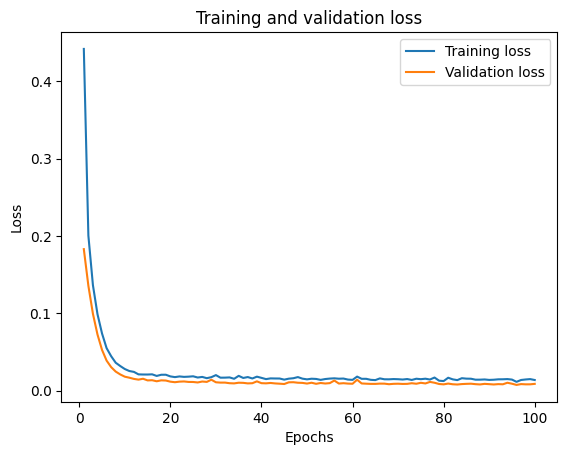

In [19]:
# Model Performance Metric Analysis 1: Training and Validation Loss Plots
loss = first_history.history['loss']
val_loss = first_history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss,  label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

From the above plot, it seems like we can use the elbow method to reduce the number of epochs to 40 during training. So after removing highly correlated features and performing hyperparameter tuning, we will then choose the top 3 hyperparametrized models. However before doing that, we need to consider training the first model under less epochs to see if that mitigates possible overfitting.

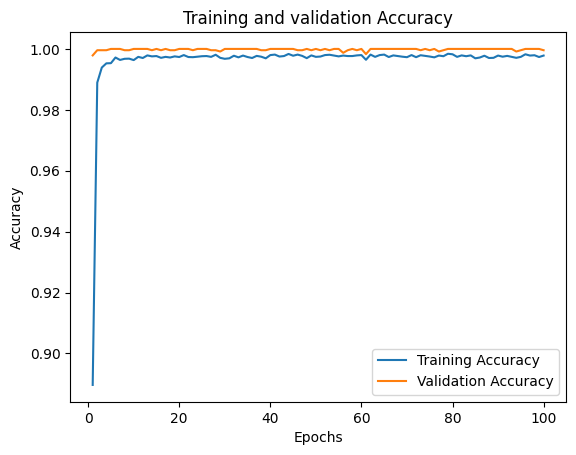

In [20]:
# Model Performance Metric Analysis 1.1: Training and Validation Set Accuracy Plot

accuracy = first_history.history['accuracy']
val_accuracy = first_history.history['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, accuracy,  label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# Model Performance Metric Analysis 1.2: Test Set Accuracy for First Model

test_loss, test_accuracy = first_model.evaluate(X_test_transformed, y_test_transformed)

print("Test loss {:.4f}".format(test_loss))
print("Test accuracy {:.4f}".format(test_accuracy))

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0084
Test loss 0.0084
Test accuracy 1.0000


As observed in the test set analysis, we see that the test accuracy is perfect at 
1.00 and the test loss is minimal at 0.0079 even with our first FNN basic architecture. Some proceeding explorations include other model performance analyses
and possibly optimizing our FNN with optimal hyperparameters found through the 
random search tuner. We also aim to reduce epochs using the elbow method and try
other techniques to reduce potential overfitting as evident from the first model's
history.

In [ ]:
# Model Performance Metric Analysis 2: Confusion Matrix for First Model

y_preds_first = first_model.predict(X_test_transformed)
y_pred = np.where(y_preds_first>0.5, 1, 0)
cm_first = confusion_matrix(y_test_transformed, y_pred)
cm_first

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


array([[ 999,    0],
       [   0, 1351]], dtype=int64)

In [ ]:
# Model Performance Metric Analysis 3: ROC-AUC Score for First Model

roc_auc_sc1 = roc_auc_score(y_test_transformed, y_pred)
print(roc_auc_sc1)

1.0


In [30]:
# Reducing Number of Epochs for Second Model 

second_history = first_model.fit(X_train_transformed, y_train_transformed, epochs=40,
                                batch_size=32, 
                                validation_data=(X_val_transformed, 
                                                 y_valid_transformed))


Epoch 1/40
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9975 - loss: 0.0141 - val_accuracy: 1.0000 - val_loss: 0.0081
Epoch 2/40
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9978 - loss: 0.0158 - val_accuracy: 1.0000 - val_loss: 0.0076
Epoch 3/40
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9976 - loss: 0.0141 - val_accuracy: 1.0000 - val_loss: 0.0076
Epoch 4/40
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9979 - loss: 0.0148 - val_accuracy: 1.0000 - val_loss: 0.0076
Epoch 5/40
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9982 - loss: 0.0126 - val_accuracy: 1.0000 - val_loss: 0.0075
Epoch 6/40
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9974 - loss: 0.0130 - val_accuracy: 1.0000 - val_loss: 0.0070
Epoch 7/40
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9985 - loss: 0.0111 - val_accuracy: 1.0000 - val_loss: 0.0077
Epoch 8/40
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9974 - loss: 0.0186 - val_accuracy: 1.

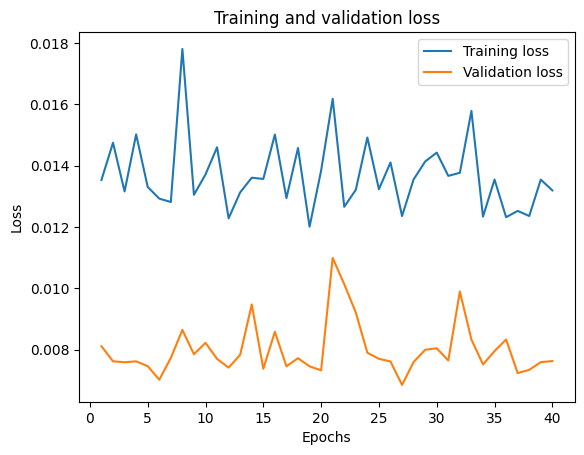

In [31]:
loss = second_history.history['loss']
val_loss = second_history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss,  label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

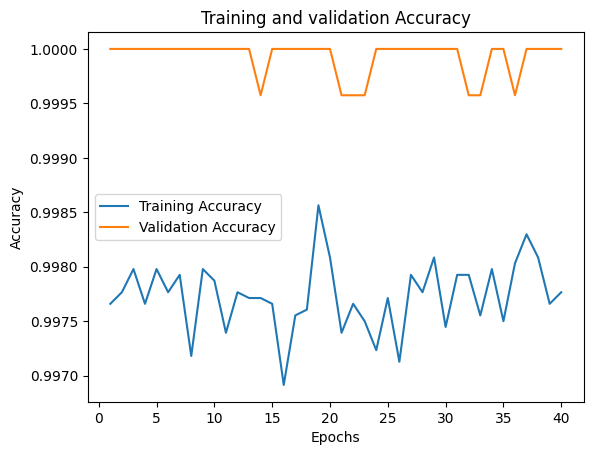

In [32]:
accuracy = second_history.history['accuracy']
val_accuracy = second_history.history['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, accuracy,  label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

5. Hyperparameter Tuning 
• Implement random search to tune at least three hyperparameters (e.g., learning 
rate, batch size, number of epochs, number of nodes in hidden layers, dropout 
rate, etc.). 
• Evaluate models based on validation performance and record training and 
validation loss per epoch. 
• Plot the learning curves for at least the top three configurations. 
• Select the best model configuration and justify your choice. 

Now after reducing the number of epochs, we must consider other potential choices for optimized hyperparameters and see if they yield promising results. Our main objective is to reduce the accuracy from 100% but ensuring that it stays between 90% or higher. We will achieve this by using the Random Tuner on a series of skeleton models to test different sets of hyperparameters, such as testing out different optimizers, finding the optimal number of neurons and hidden layers, and optimal learning rates.

In [43]:
# Hyperparameter Tuning via Random Search Part 1:
# Here we build the skeleton model that will used to perform random search
# hyperparameter tuning. 

def skeleton_model(hyper):
    n_hidden = hyper.Int("n_hidden", min_value=0, max_value=10, default=2)
    n_neurons = hyper.Int("n_neurons", min_value=16, max_value=256)
    learning_rate = hyper.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                                sampling="log") 
    optimizer = hyper.Choice("optimizer", 
                             values = ["SGD", "Adam", "RMSProp", "Nadam", "Adamax",
                                       ])
    
    if optimizer == "SGD":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == "Adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == "RMSProp":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate,
                                                rho = 0.9)
    elif optimizer == "Nadam":
        optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adamax(learning_rate=learning_rate)

    samp_model = tf.keras.Sequential()
    samp_model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        samp_model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    samp_model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    samp_model.compile(loss="binary_crossentropy", optimizer=optimizer,
                       metrics=["accuracy"])
    return samp_model

In [44]:
# Hyperparameter Tuning via Random Search Part 2: 
# Here we will run the random search tuner on iterations of each proposed
# skeleton model and find the best hyperparameters for our final 
# feed-forward neural network.

random_search_tuner = kt.RandomSearch(
    skeleton_model, objective="val_accuracy", max_trials=12,
    seed=42
)
random_search_tuner.search(X_train_transformed, y_train_transformed, epochs=10, verbose=1,
                           validation_data=(X_val_transformed, y_valid_transformed))

Reloading Tuner from .\untitled_project\tuner0.json


In [45]:
# Hyperparameter Tuning via Random Search Part 3:
# We now find the top 3 sets of model architecture hyperparameters from the 
# random search tuner.

top_3_hps = random_search_tuner.get_best_hyperparameters(num_trials=3)

for i, hp in enumerate(top_3_hps):
    print(f"Top {i+1} hyperparameters:") 
    print(hp.values)

Top 1 hyperparameters:
{'n_hidden': 10, 'n_neurons': 123, 'learning_rate': 0.0008960175671873151, 'optimizer': 'RMSProp'}
Top 2 hyperparameters:
{'n_hidden': 8, 'n_neurons': 51, 'learning_rate': 0.0003491260272208854, 'optimizer': 'RMSProp'}
Top 3 hyperparameters:
{'n_hidden': 5, 'n_neurons': 74, 'learning_rate': 0.00905127409782462, 'optimizer': 'Nadam'}


After hyperparameter tuning, we can now see that the random tuner found 3 sets of optimized hyperparameters with the best number of hidden layers, best number of neurons, best learning rate, and the best optimizer to use. We will now proceed by plotting the learning curves (both accuracy and loss curves) by using these new hyperparameters, and then select the best model that generalizes the data the best. 

Now since we have reduced the number of epochs during training and found the top 3 configurations of hyperparameters, we will now perform feature selection in order to remove any highly correlated features and to mitigate multicollinearity caused by redundant information. We do this by first retrieving the correlation matrix and then removing the most highly correlated features with the thereshold of 0.8. We chose this threshold as any features greater than 0.8 can be considered "too high", namely too close to 1. We then also display the features to keep via a new correlation matrix visualization. These features will then be used in the final model assessments.

In [47]:
phishing_corr_mat = phishing_samp.corr()
phishing_corr_mat

,URLLength,DomainLength,IsDomainIP,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,NoOfSubDomain,NoOfLettersInURL,LetterRatioInURL,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
URLLength,1.000000,0.264245,0.249462,-0.431781,-0.248412,-0.010579,-0.252644,0.058069,0.926732,0.312834,...,-0.049295,-0.024185,-0.130559,-0.064940,-0.073073,-0.098200,-0.097958,-0.034774,-0.086054,-0.239103
DomainLength,0.264245,1.000000,-0.035868,-0.415045,-0.576647,0.031474,-0.170187,0.399740,0.354844,0.541448,...,-0.056494,-0.033604,-0.191743,-0.076827,-0.082627,-0.125558,-0.119992,-0.048147,-0.098377,-0.273456
IsDomainIP,0.249462,-0.035868,1.000000,-0.108492,-0.094307,-0.047821,-0.102280,0.080202,0.265297,-0.008739,...,-0.020586,-0.007416,-0.029169,-0.015306,-0.019720,-0.027168,-0.022590,-0.009184,-0.019888,-0.055586
URLSimilarityIndex,-0.431781,-0.415045,-0.108492,1.000000,0.576207,0.167151,0.573552,-0.057729,-0.544753,-0.477508,...,0.284925,0.082250,0.616910,0.232877,0.290759,0.393070,0.347110,0.128739,0.314459,0.858393
CharContinuationRate,-0.248412,-0.576647,-0.094307,0.576207,1.000000,0.240563,0.355026,-0.487437,-0.311745,-0.294994,...,0.176195,0.056182,0.351250,0.138043,0.161679,0.232056,0.190935,0.071515,0.176255,0.466570
TLDLegitimateProb,-0.010579,0.031474,-0.047821,0.167151,0.240563,1.000000,0.278193,-0.247961,-0.000099,0.132719,...,0.117970,0.024559,0.117891,0.057147,0.029149,0.067341,0.039522,0.028096,0.051245,0.104071
URLCharProb,-0.252644,-0.170187,-0.102280,0.573552,0.355026,0.278193,1.000000,-0.069901,-0.255368,0.056964,...,0.151283,0.058590,0.351477,0.128438,0.168576,0.219334,0.181960,0.068685,0.173154,0.469641
NoOfSubDomain,0.058069,0.399740,0.080202,-0.057729,-0.487437,-0.247961,-0.069901,1.000000,0.051811,-0.044034,...,-0.028292,-0.016367,-0.009027,-0.015294,-0.005200,-0.015771,0.000569,0.000204,-0.007995,-0.007152
NoOfLettersInURL,0.926732,0.354844,0.265297,-0.544753,-0.311745,-0.000099,-0.255368,0.051811,1.000000,0.508291,...,-0.072760,-0.030340,-0.178744,-0.085579,-0.096817,-0.132915,-0.129348,-0.046433,-0.113057,-0.313292
LetterRatioInURL,0.312834,0.541448,-0.008739,-0.477508,-0.294994,0.132719,0.056964,-0.044034,0.508291,1.000000,...,-0.079433,-0.029336,-0.228396,-0.097809,-0.104703,-0.152963,-0.153071,-0.058073,-0.124452,-0.350457


Selected features after correlation-based feature selection:
Index(['URLLength', 'DomainLength', 'IsDomainIP', 'URLSimilarityIndex',
       'CharContinuationRate', 'TLDLegitimateProb', 'URLCharProb',
       'NoOfSubDomain', 'LetterRatioInURL', 'DegitRatioInURL',
       'NoOfQMarkInURL', 'SpacialCharRatioInURL', 'IsHTTPS', 'LineOfCode',
       'LargestLineLength', 'HasTitle', 'DomainTitleMatchScore', 'HasFavicon',
       'Robots', 'IsResponsive', 'NoOfURLRedirect', 'NoOfSelfRedirect',
       'HasDescription', 'NoOfPopup', 'NoOfiFrame', 'HasExternalFormSubmit',
       'HasSocialNet', 'HasSubmitButton', 'HasHiddenFields',
       'HasPasswordField', 'Bank', 'Pay', 'Crypto', 'HasCopyrightInfo',
       'NoOfImage', 'NoOfCSS', 'NoOfJS', 'NoOfSelfRef', 'NoOfEmptyRef',
       'NoOfExternalRef'],
      dtype='object')


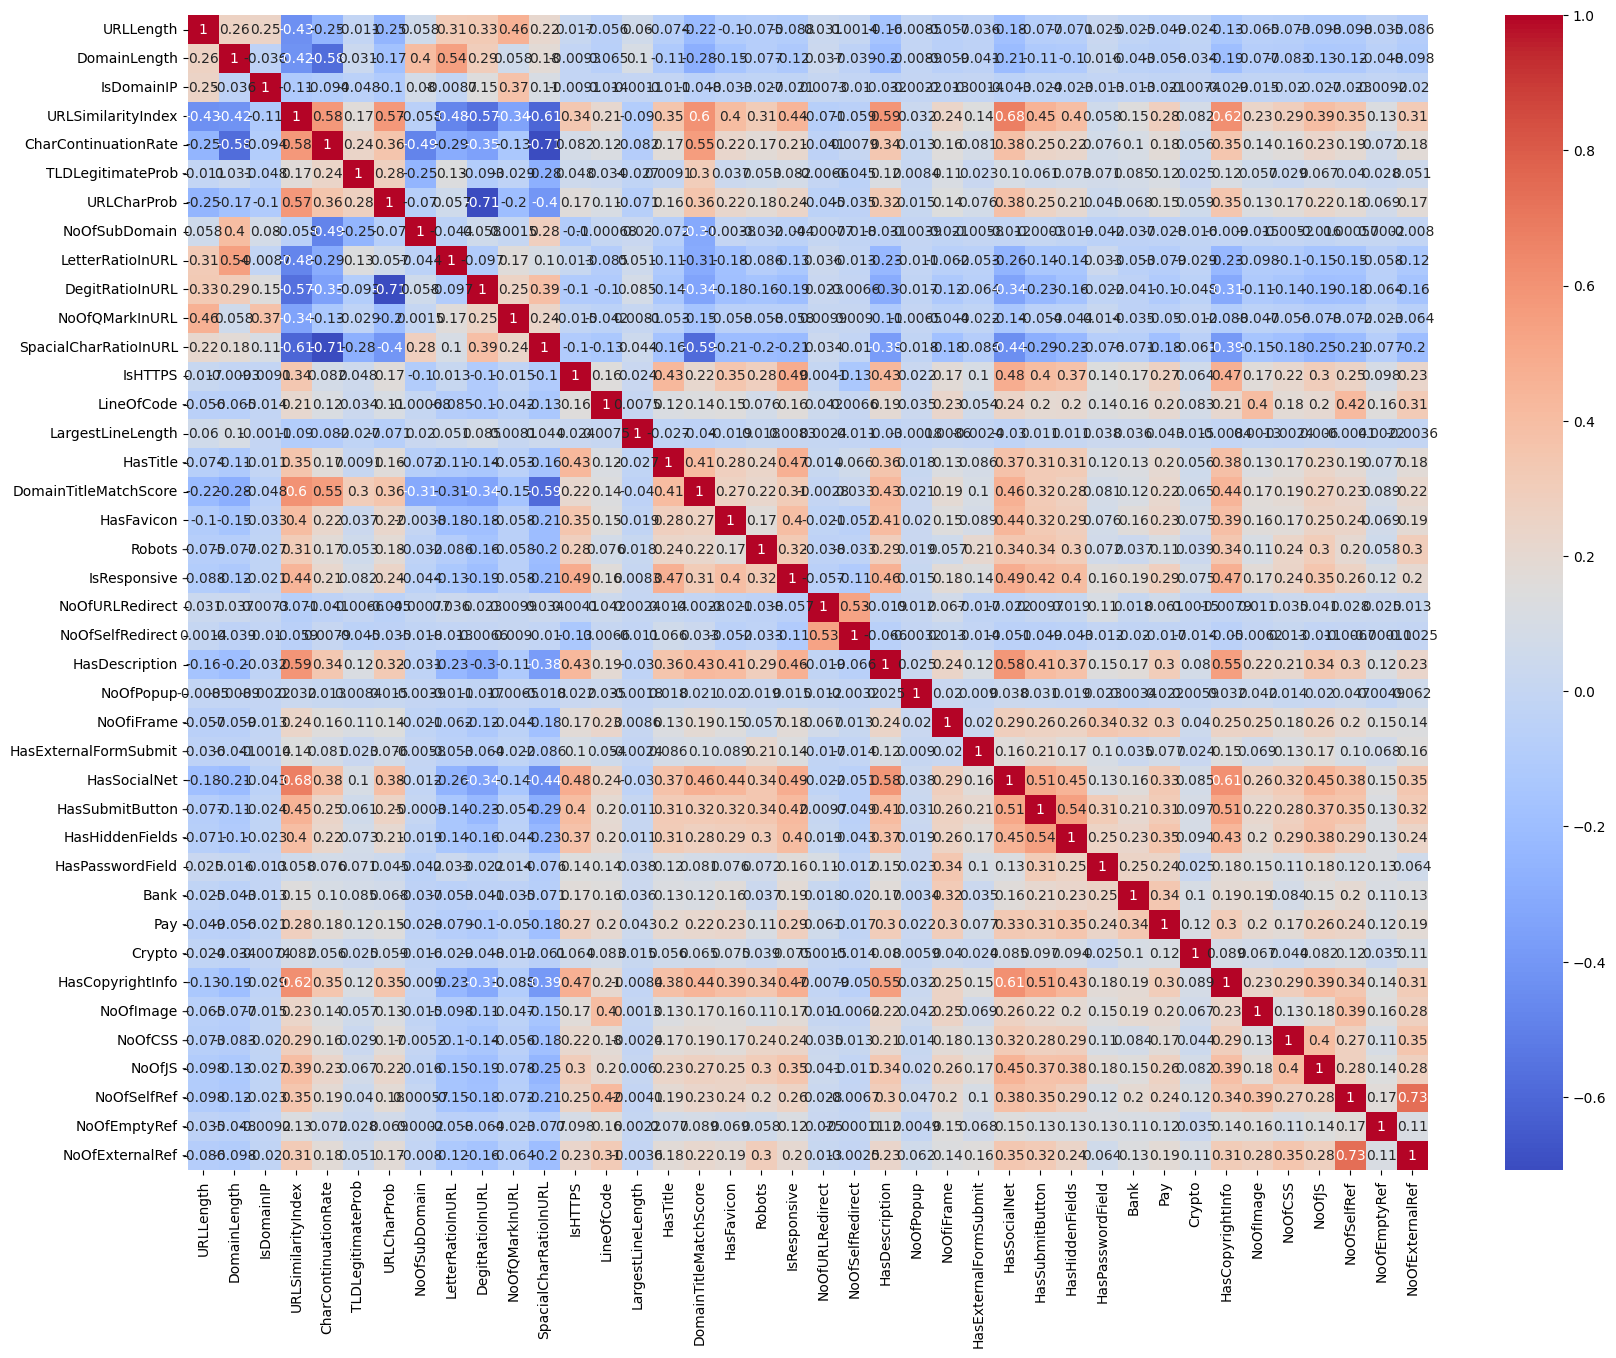

In [51]:
upper_triag = phishing_corr_mat.where(np.triu(np.ones(phishing_corr_mat.shape), 
                                              k=1).astype(bool))
to_drop = [column for column in upper_triag.columns if any(upper_triag[column] > 0.8)]
phishing_reduced = phishing_samp.drop(columns=to_drop)

print("Selected features after correlation-based feature selection:")
print(phishing_reduced.columns)

plt.figure(figsize=(20, 15))
sns.heatmap(phishing_reduced.corr(), annot=True, cmap='coolwarm') 
plt.show()

In [54]:
# Removing the highly correlated features and creating final data splits. 

X_train, X_temp, y_train, y_temp = train_test_split(X_mat, y_target, test_size=0.2,
                                                    random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5,
                                                    random_state=42)

numerical_cont = ["URLLength", "DomainLength", "URLSimilarityIndex", "CharContinuationRate",
                 "TLDLegitimateProb", "URLCharProb",
                 "LetterRatioInURL", "NoOfImage", "NoOfCSS",
                 "NoOfJS", "NoOfSelfRef", "NoOfEmptyRef", "NoOfExternalRef",
                 "NoOfSubDomain", "LargestLineLength", "LineOfCode",
                 "DegitRatioInURL", "NoOfQMarkInURL",
                 "SpacialCharRatioInURL", "DomainTitleMatchScore",
                 "NoOfURLRedirect", "NoOfSelfRedirect", "NoOfPopup",
                 "NoOfiFrame"]

binary_feat = ["IsDomainIP", "Bank", "Pay", "Crypto", "HasCopyrightInfo",
                    "IsHTTPS", "HasTitle", "HasFavicon", "Robots", "IsResponsive",
                     "HasDescription", "HasExternalFormSubmit", "HasSocialNet",
                      "HasSubmitButton", "HasHiddenFields", "HasPasswordField"]

preprocessor = ColumnTransformer(
    transformers=[
        ('continuous', StandardScaler(), numerical_cont),
        ('binary', 'passthrough', binary_feat)
    ])

X_train_transformed = preprocessor.fit_transform(X_train)
X_val_transformed = preprocessor.transform(X_valid)
X_test_transformed = preprocessor.transform(X_test)

print("Train shape: ", X_train_transformed.shape)
print("Valid shape: ", X_val_transformed.shape)
print("Test shape: ", X_test_transformed.shape)

label_encoder = LabelEncoder()
y_train_transformed = label_encoder.fit_transform(y_train)
y_valid_transformed = label_encoder.transform(y_valid)
y_test_transformed = label_encoder.transform(y_test)

Train shape:  (18799, 40)
Valid shape:  (2350, 40)
Test shape:  (2350, 40)


c:\Users\coryg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\coryg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\Users\coryg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


6. Training and Validation 
• Train the model on the training set and validate it using the best configuration 
from random search. 
• Show evidence of improvement through the tuning process. 

7. Test Set Evaluation 
• Evaluate the performance of the final model on the test set using appropriate 
metrics (e.g., accuracy or ROC-AUC). 
• Provide a confusion matrix. 

NOTE: I have included each of the question requirements under one cell for each of the top 3 hyperparameter configurations. Hence you will see an associated learning curve(s) graph and confusion matrix for each new configuration.

Final Model A Construction and Training

In [57]:
# Final Model Assessment A

first_model = tf.keras.Sequential([
    tf.keras.layers.Dense(123, activation="relu", input_shape=(40,),
                          kernel_regularizer=l2(0.001), 
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(123, activation="relu", kernel_regularizer=l2(0.001),
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=l2(0.001),
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=l2(0.001),
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(16, activation="relu", kernel_regularizer=l2(0.001),
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

first_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0008960175671873151),
                    loss="binary_crossentropy",
                    metrics=["accuracy"])

first_history = first_model.fit(X_train_transformed, y_train_transformed, epochs=20,
                                batch_size=32, 
                                validation_data=(X_val_transformed, 
                                                 y_valid_transformed))

Epoch 1/20
588/588 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6238 - loss: 1.5437 - val_accuracy: 0.9983 - val_loss: 0.4111
Epoch 2/20
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9814 - loss: 0.3605 - val_accuracy: 0.9991 - val_loss: 0.1031
Epoch 3/20
588/588 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9941 - loss: 0.1048 - val_accuracy: 0.9991 - val_loss: 0.0435
Epoch 4/20
588/588 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9967 - loss: 0.0488 - val_accuracy: 0.9996 - val_loss: 0.0251
Epoch 5/20
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9959 - loss: 0.0352 - val_accuracy: 1.0000 - val_loss: 0.0194
Epoch 6/20
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9965 - loss: 0.0293 - val_accuracy: 0.9991 - val_loss: 0.0185
Epoch 7/20
588/588 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9972 - loss: 0.0259 - val_accuracy: 0.9991 - val_loss: 0.0172
Epoch 8/20
588/588 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9963 - loss: 0.0262 - val_accuracy: 1.

Learning Curves for Final Model A

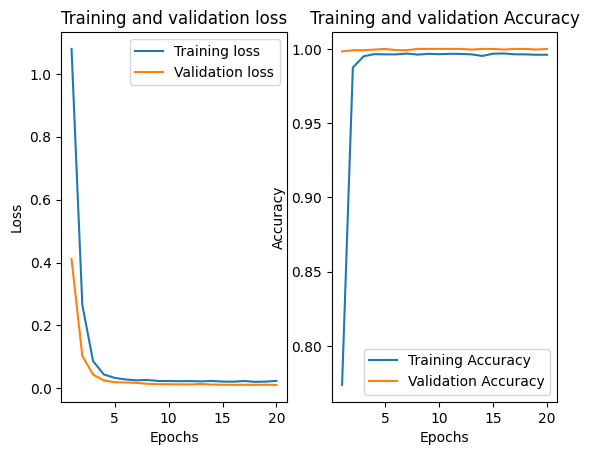

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0108
Test loss 0.0109
Test accuracy 1.0000
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


array([[ 999,    0],
       [   0, 1351]], dtype=int64)

In [63]:
loss = first_history.history['loss']
val_loss = first_history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.subplot(1,2,1)
plt.plot(epochs, loss,  label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

accuracy = first_history.history['accuracy']
val_accuracy = first_history.history['val_accuracy']

plt.subplot(1,2,2)
plt.plot(epochs, accuracy,  label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

test_loss, test_accuracy = first_model.evaluate(X_test_transformed, y_test_transformed)

print("Test loss {:.4f}".format(test_loss))
print("Test accuracy {:.4f}".format(test_accuracy))

y_preds_first = first_model.predict(X_test_transformed)
y_pred = np.where(y_preds_first>0.5, 1, 0)
cm_first = confusion_matrix(y_test_transformed, y_pred)
cm_first

Model Construction for Final Model B

In [64]:
first_model = tf.keras.Sequential([
    tf.keras.layers.Dense(51, activation="relu", input_shape=(40,),
                          kernel_regularizer=l2(0.001), 
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(51, activation="relu", kernel_regularizer=l2(0.001),
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=l2(0.001),
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(16, activation="relu", kernel_regularizer=l2(0.001),
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

first_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0003491260272208854),
                    loss="binary_crossentropy",
                    metrics=["accuracy"])

first_history = first_model.fit(X_train_transformed, y_train_transformed, epochs=20,
                                batch_size=32, 
                                validation_data=(X_val_transformed, 
                                                 y_valid_transformed))

c:\Users\coryg\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
588/588 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5566 - loss: 1.6658 - val_accuracy: 0.9460 - val_loss: 0.6239
Epoch 2/20
588/588 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7851 - loss: 0.7105 - val_accuracy: 0.9962 - val_loss: 0.2663
Epoch 3/20
588/588 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9440 - loss: 0.3812 - val_accuracy: 0.9983 - val_loss: 0.1878
Epoch 4/20
588/588 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9781 - loss: 0.2401 - val_accuracy: 0.9991 - val_loss: 0.1329
Epoch 5/20
588/588 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9896 - loss: 0.1527 - val_accuracy: 0.9991 - val_loss: 0.0900
Epoch 6/20
588/588 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9897 - loss: 0.1137 - val_accuracy: 0.9991 - val_loss: 0.0638
Epoch 7/20
588/588 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9927 - loss: 0.0943 - val_accuracy: 0.9996 - val_loss: 0.0494
Epoch 8/20
588/588 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9945 - loss: 0.0635 - val_accuracy: 0.

Learning Curves for Final Model B

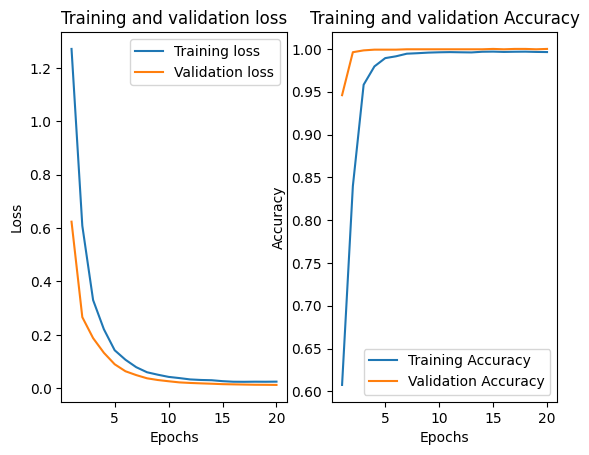

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0125
Test loss 0.0128
Test accuracy 0.9996
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


array([[ 998,    1],
       [   0, 1351]], dtype=int64)

In [65]:
loss = first_history.history['loss']
val_loss = first_history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.subplot(1,2,1)
plt.plot(epochs, loss,  label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

accuracy = first_history.history['accuracy']
val_accuracy = first_history.history['val_accuracy']

plt.subplot(1,2,2)
plt.plot(epochs, accuracy,  label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

test_loss, test_accuracy = first_model.evaluate(X_test_transformed, y_test_transformed)

print("Test loss {:.4f}".format(test_loss))
print("Test accuracy {:.4f}".format(test_accuracy))

y_preds_first = first_model.predict(X_test_transformed)
y_pred = np.where(y_preds_first>0.5, 1, 0)
cm_first = confusion_matrix(y_test_transformed, y_pred)
cm_first

Model Construction for Final Model C

In [66]:
first_model = tf.keras.Sequential([
    tf.keras.layers.Dense(74, activation="relu", input_shape=(40,),
                          kernel_regularizer=l2(0.001), 
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=l2(0.001),
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=l2(0.001),
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

first_model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.00905127409782462),
                    loss="binary_crossentropy",
                    metrics=["accuracy"])

first_history = first_model.fit(X_train_transformed, y_train_transformed, epochs=20,
                                batch_size=32, 
                                validation_data=(X_val_transformed, 
                                                 y_valid_transformed))

Epoch 1/20


c:\Users\coryg\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


588/588 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9719 - loss: 0.2595 - val_accuracy: 0.9809 - val_loss: 0.0979
Epoch 2/20
588/588 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9957 - loss: 0.0538 - val_accuracy: 0.9991 - val_loss: 0.0333
Epoch 3/20
588/588 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9977 - loss: 0.0368 - val_accuracy: 1.0000 - val_loss: 0.0421
Epoch 4/20
588/588 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9970 - loss: 0.0504 - val_accuracy: 1.0000 - val_loss: 0.0211
Epoch 5/20
588/588 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9962 - loss: 0.0422 - val_accuracy: 1.0000 - val_loss: 0.0258
Epoch 6/20
588/588 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9974 - loss: 0.0380 - val_accuracy: 1.0000 - val_loss: 0.0414
Epoch 7/20
588/588 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9969 - loss: 0.0455 - val_accuracy: 0.9996 - val_loss: 0.0397
Epoch 8/20
588/588 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9980 - loss: 0.0393 - val_accuracy: 1.0000 - val_

Learning Curves for Final Model C

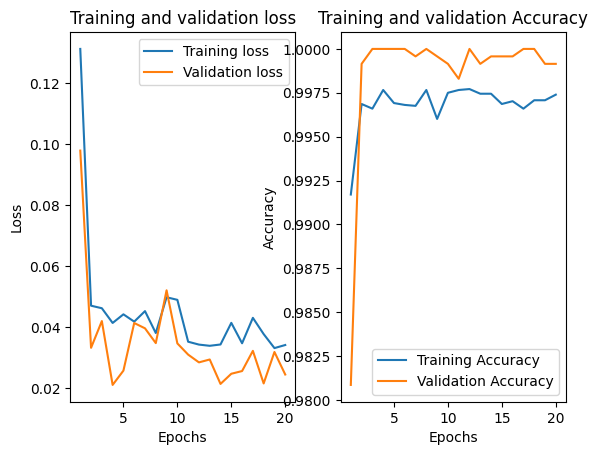

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0232
Test loss 0.0232
Test accuracy 1.0000
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


array([[ 999,    0],
       [   0, 1351]], dtype=int64)

In [67]:
loss = first_history.history['loss']
val_loss = first_history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.subplot(1,2,1)
plt.plot(epochs, loss,  label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

accuracy = first_history.history['accuracy']
val_accuracy = first_history.history['val_accuracy']

plt.subplot(1,2,2)
plt.plot(epochs, accuracy,  label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

test_loss, test_accuracy = first_model.evaluate(X_test_transformed, y_test_transformed)

print("Test loss {:.4f}".format(test_loss))
print("Test accuracy {:.4f}".format(test_accuracy))

y_preds_first = first_model.predict(X_test_transformed)
y_pred = np.where(y_preds_first>0.5, 1, 0)
cm_first = confusion_matrix(y_test_transformed, y_pred)
cm_first

8. Model Interpretation 
• Interpret the results. Discuss which features contributed most to the model’s 
performance and any limitations of the model. 

9. Conclusion 
• Summarize your findings, including key insights from the preprocessing, 
modeling, and evaluation steps. 

After considering the final models in our report, we notice that final model B generalizes the phishing data the best since out of all the models trained over 20 epochs, this model did not have a perfect accuracy, yet a high one nonethless of 99.6%, where it only had 1 false positive according to its confusion matrix. The removal of the highly correlated features aided in producing the results of our final model. Therefore according to our hypotheses listed earlier in part 1, we reject the null hypothesis and we have evidence to conclude that our FNN for model B has increased in accuracy and generalizes the dataset well.

In terms of the features that contributed most to the model's performance, the following features out of the original 56 features provided us with the best accuracy and model configuration. A few noteworthy limitations of this FNN in particular is that we only has considered one potential split of the dataset which was the 80-10-10 split. The most optimized model may change if we reduce the amount of data attributed to training, say a 60-20-20 split. However for this model, we needed a bigger proportion of training data and hence stayed with the 80-10-10 split. Another limitation of the model is that we did not consider any other special optimization techniques such as learning rate scheduling in order to optimize the learning rate of our optimizers and did not consider using other activation functions for the hidden layers such as Selu, Gelu, or Swish mainly due to the fact that all of the training and validation of this FNN almost rendered my personal machine broken. Nonetheless, we have attained the following model as our best model from our findings through the evaluation steps of using the learning curves and the confusion matrix in order to get a more robust analysis of the validation accuracies.